In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sstats.sigp_AP as sigp

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=7, cores=7,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [7]:
ds_low = xr.open_dataset('/home1/datawork/zcaspar/mit4320/ds_synthetic_lf.nc').compute()
#/Users/zcaspar/codes/mit4320/ds_lf.nc

In [13]:
dt = 1/24
lags = np.arange(0,ds_low.time.size,dt)
ds_autocov = sigp.correlate(ds_low.u_bar,ds_low.u_bar,biased=True)#.persist()

In [14]:
ds_autocov

<xarray.DataArray 'u_bar_u_bar' (filt: 3, T: 3, draw: 500, lags: 7200)>
dask.array<transpose, shape=(3, 3, 500, 7200), dtype=float64, chunksize=(3, 3, 500, 7200), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) float64 2.0 20.0 200.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * filt     (filt) int64 0 1 2
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0

In [15]:
ds = ds_autocov.compute()

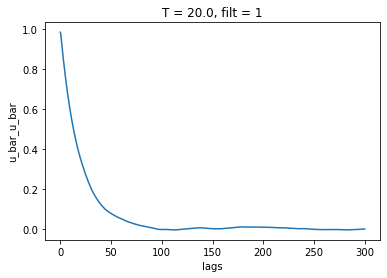

In [16]:
ds.isel(filt=1,T=1).mean('draw').plot()

In [17]:
ds.to_netcdf('/home1/datawork/zcaspar/mit4320/lf_autocov.nc')

In [3]:
ds_hf = xr.open_zarr('/home1/datawork/zcaspar/mit4320/ds_synthetic_total.zarr').persist()

In [5]:
dt = 1/24
#lags = np.arange(0,ds_low.time.size,dt)
v1,v2 = ds_hf['M2_demodulated_real'],ds_hf['M2_demodulated_real']
ds_autocov_hf = sigp.correlate(v1,v2,biased=False).persist()

In [7]:
v1,v2 = ds_hf['M2_demodulated_real'],ds_hf['M2_demodulated_imag']
ds_cov_hf = sigp.correlate(v1,v2,biased=False).persist()

In [8]:
v1,v2 = ds_hf['MS_demodulated_real'],ds_hf['MS_demodulated_real']
ds_autocov_hf_MS = sigp.correlate(v1,v2,biased=False).persist()

In [9]:
v1,v2 = ds_hf['MS_demodulated_real'],ds_hf['MS_demodulated_imag']
ds_cov_hf_MS = sigp.correlate(v1,v2,biased=False).persist()

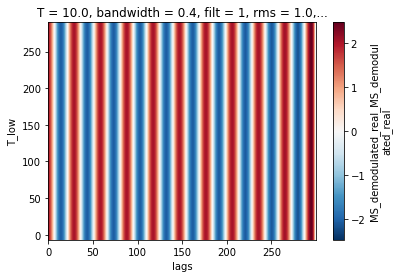

In [10]:
ds_autocov_hf_MS.sel(T=10,rms=1,signal='coherent',bandwidth=0.4).mean('draw').plot()

In [11]:
ds = xr.Dataset({'M2_real_real' : ds_autocov_hf,'MS_real_real' : ds_autocov_hf_MS,
                 'M2_real_imag' : ds_cov_hf,'MS_real_imag' : ds_cov_hf_MS})

In [12]:
ds = ds.compute()

distributed.scheduler - ERROR - Couldn't gather keys {"('transpose-82d9934809c1e148355f959eda4c3417', 1, 2, 2, 0, 0, 0, 0)": ['tcp://10.148.1.58:37337'], "('transpose-82d9934809c1e148355f959eda4c3417', 2, 2, 1, 0, 0, 0, 0)": ['tcp://10.148.1.39:52800'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 0, 0, 3, 0, 0, 0, 0)": ['tcp://10.148.1.60:53639'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 1, 2, 1, 0, 0, 0, 0)": ['tcp://10.148.0.222:37925'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 2, 2, 2, 0, 0, 0, 0)": ['tcp://10.148.0.224:42052'], "('transpose-0f5dc3d99c53f4286c50839a7c32c1b2', 2, 1, 1, 0, 0, 0, 0)": ['tcp://10.148.1.39:52800'], "('transpose-0f5dc3d99c53f4286c50839a7c32c1b2', 2, 1, 0, 0, 0, 0, 0)": ['tcp://10.148.0.224:42052'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 2, 0, 0, 0, 0, 0, 0)": ['tcp://10.148.1.39:55158'], "('transpose-82d9934809c1e148355f959eda4c3417', 0, 0, 3, 0, 0, 0, 0)": ['tcp://10.148.0.224:53784'], "('transpose-0f5dc3d99c53f4286c50839a7c32c

KeyboardInterrupt: 

In [13]:
ds.to_zarr('/home1/datawork/zcaspar/mit4320/total_autocov.zarr')

distributed.scheduler - ERROR - Couldn't gather keys {"('transpose-82d9934809c1e148355f959eda4c3417', 1, 2, 2, 0, 0, 0, 0)": ['tcp://10.148.1.58:37337'], "('transpose-82d9934809c1e148355f959eda4c3417', 2, 2, 1, 0, 0, 0, 0)": ['tcp://10.148.1.39:52800'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 0, 0, 3, 0, 0, 0, 0)": ['tcp://10.148.1.60:53639'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 1, 2, 1, 0, 0, 0, 0)": ['tcp://10.148.0.222:37925'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 2, 2, 2, 0, 0, 0, 0)": ['tcp://10.148.0.224:42052'], "('transpose-0f5dc3d99c53f4286c50839a7c32c1b2', 2, 1, 1, 0, 0, 0, 0)": ['tcp://10.148.1.39:52800'], "('transpose-0f5dc3d99c53f4286c50839a7c32c1b2', 2, 1, 0, 0, 0, 0, 0)": ['tcp://10.148.0.224:42052'], "('transpose-c7004ebdcff511ea4bfce4281f7ef54a', 2, 0, 0, 0, 0, 0, 0)": ['tcp://10.148.1.39:55158'], "('transpose-82d9934809c1e148355f959eda4c3417', 0, 0, 3, 0, 0, 0, 0)": ['tcp://10.148.0.224:53784'], "('transpose-0f5dc3d99c53f4286c50839a7c32c

KeyboardInterrupt: 

In [21]:
ds_hf = xr.open_zarr('/home1/datawork/zcaspar/mit4320/ds_synthetic_total.zarr').persist()
#ds_hf = ds_hf.compute()

In [22]:
E = {}
for v in ['M2','MS']:
    ds_hf[v+'_demodulated'] = ds_hf[v+'_demodulated_real']+1j*ds_hf[v+'_demodulated_imag']
    E[v] = (abs(ds_hf[v+'_demodulated'])**2).persist()

In [23]:
E

{'M2': <xarray.DataArray 'M2_demodulated' (bandwidth: 3, signal: 3, rms: 4, T_low: 3, draw: 500, T: 4, time: 7200)>
 dask.array<pow, shape=(3, 3, 4, 3, 500, 4, 7200), dtype=float64, chunksize=(1, 1, 1, 3, 500, 4, 7200), chunktype=numpy.ndarray>
 Coordinates:
   * T          (T) float64 5.0 10.0 20.0 40.0
   * T_low      (T_low) float64 2.0 20.0 200.0
   * bandwidth  (bandwidth) float64 0.2 0.4 0.6
   * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
     filt       int64 ...
   * rms        (rms) float64 0.01 0.1 1.0 2.0
   * signal     (signal) <U10 'coherent' 'mixed' 'incoherent'
   * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0,
 'MS': <xarray.DataArray 'MS_demodulated' (bandwidth: 3, signal: 3, rms: 4, T_low: 3, draw: 500, T: 4, time: 7200)>
 dask.array<pow, shape=(3, 3, 4, 3, 500, 4, 7200), dtype=float64, chunksize=(1, 1, 1, 3, 500, 4, 7200), chunktype=numpy.ndarray>
 Coordinates:
   * T          (T) float64 5.0 10.0 20.0 40

In [24]:
ds_E = xr.Dataset({v : E[v].rename(v).compute() for v in ['M2','MS']})
    
#ds_hf.to_netcdf('/home1/datawork/zcaspar/mit4320/ds_synthetic_hf.nc')

In [25]:
ds_E

<xarray.Dataset>
Dimensions:    (T: 4, T_low: 3, bandwidth: 3, draw: 500, rms: 4, signal: 3, time: 7200)
Coordinates:
  * T          (T) float64 5.0 10.0 20.0 40.0
  * T_low      (T_low) float64 2.0 20.0 200.0
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    filt       int64 1
  * rms        (rms) float64 0.01 0.1 1.0 2.0
  * signal     (signal) <U10 'coherent' 'mixed' 'incoherent'
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
Data variables:
    M2         (bandwidth, signal, rms, T_low, draw, T, time) float64 0.00395...
    MS         (bandwidth, signal, rms, T_low, draw, T, time) float64 0.00459...

In [26]:
ds_E.to_netcdf('/home1/datawork/zcaspar/mit4320/ds_synthetic_total.nc')

In [ ]:
#client.restart()
cluster.close()